Import Dependencies

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras import layers

Preprocessing

In [4]:
#(train_images, train_labels), (test_images, test_labels) = tfds.load("colorectal_histology", split=["train", "test"])
ds = tfds.load("colorectal_histology", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.2IOGF8_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['filename', 'image', 'label'])

In [ ]:
"ds.as_numpy_iterator().next()['filename']

b'160F4_CRC-Prim-HE-08_021.tif_Row_1201_Col_1651.tif'

In [ ]:
len(ds)

5000

In [ ]:
class_names = ['tumour epithelium', 'simple stroma', 'complex stroma', 'immune cell conglomerates', 'debris and mucus', 'mucosal glands',
               'adipose tissue', 'background']

In [8]:
dataset, info = tfds.load("colorectal_histology", split=f'train', as_supervised=True,with_info=True, shuffle_files=True)
dataset = dataset.shuffle(buffer_size=5000,reshuffle_each_iteration = False)
dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))

In [12]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
print(f'dataset type {type(dataset)} with {len(dataset)} images')

dataset type <class 'tensorflow.python.data.ops.map_op._MapDataset'> with 5000 images


In [ ]:
print(info.supervised_keys)

('image', 'label')


In [ ]:
print(info.features.items())

dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


In [40]:
batch_size = 64
valid_data = dataset.take(1000)
valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data = dataset.skip(1000).take(1000)
test_data = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = dataset.skip(2000).take(3000)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

Visualize the Data

In [53]:
dataiterator = ds.as_numpy_iterator()

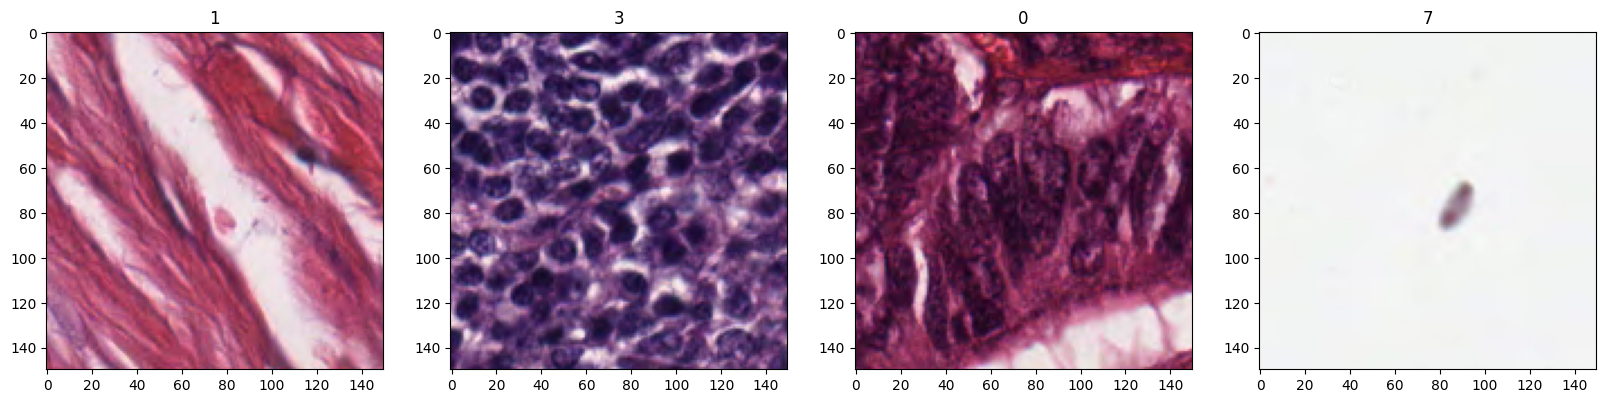

In [56]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(sample['image'])
    ax[idx].title.set_text(sample['label'])

CNN Model

In [41]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((150, 150, 3)),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
    ], name='cnn_model')

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
print(model.summary())

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 573,000 (2.19 MB)

 Trainable params: 573,000 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

None


In [43]:
CC_CNN = model.fit(train_data, validation_data=valid_data, epochs=100)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 424ms/step - accuracy: 0.1693 - loss: 1.8948 - val_accuracy: 0.3410 - val_loss: 1.5581
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3113 - loss: 1.5180 - val_accuracy: 0.3730 - val_loss: 1.3774
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4151 - loss: 1.2913 - val_accuracy: 0.4480 - val_loss: 1.0968
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5123 - loss: 1.0869 - val_accuracy: 0.5680 - val_loss: 0.9721
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5466 - loss: 1.0010 - val_accuracy: 0.5890 - val_loss: 0.9882
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6085 - loss: 0.9483 - val_accuracy: 0.6520 - val_loss: 0.8970
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6199 - loss: 0.9094 - val_accuracy: 0.5620 - val_loss: 0.9671
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6085 - loss: 0.9387 - val_accuracy: 

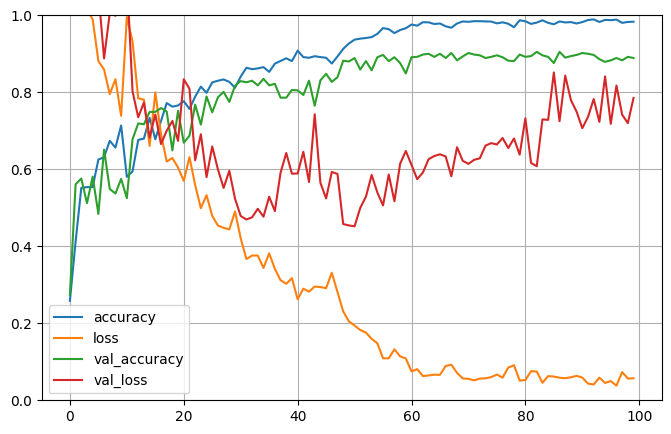

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9067 - loss: 0.6612
[0.6114936470985413, 0.9089999794960022]


In [ ]:
pd.DataFrame(CC_CNN.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(model.evaluate(test_data))

In [ ]:
val_accuracies = CC_CNN.history['val_accuracy']
np.max(val_accuracies)

0.9049999713897705

In [ ]:
val_losses = CC_CNN.history['val_loss']

In [ ]:
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
best_epoch

83

Conditional Generative Adversarial Network

In [28]:
def filter_class_0(image, label):
    return tf.equal(label, 0)

class_0_dataset = dataset.filter(filter_class_0)

In [26]:
class_0_dataset

<_FilterDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
class_0_dataset = class_0_dataset.batch(32)
class_0_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
batch_size = 64
valid_data = class_0_dataset.take(1000)
valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data = class_0_dataset.skip(1000).take(1000)
test_data = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = class_0_dataset.skip(2000).take(3000)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(150 * 150 * 3, activation='tanh'))
    model.add(layers.Reshape((150, 150, 3)))
    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(150, 150, 3), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [19]:
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 25
BATCH_SIZE = 32 # Add batch size

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Use batch size here

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

for epoch in range(EPOCHS):
    for image_batch in class_0_dataset.batch(BATCH_SIZE): # Batch the dataset
        train_step(image_batch)

In [39]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    return predictions
    # You can save the generated images here

seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, EPOCHS, seed)

<tf.Tensor: shape=(25, 150, 150, 3), dtype=float32, numpy=
array([[[[ 0.19056842,  0.35265893,  0.7645171 ],
         [ 0.6203838 ,  0.4353628 ,  0.6031262 ],
         [ 0.9009201 ,  0.6691551 ,  0.7600682 ],
         ...,
         [ 0.38400674,  0.3977467 ,  0.42473996],
         [ 0.24915451,  0.10964423,  0.36000302],
         [ 0.68418133,  0.08850516,  0.37422916]],

        [[ 0.38251093,  0.6180907 ,  0.46453196],
         [ 0.84498465,  0.5368596 ,  0.8309236 ],
         [ 0.87803763,  0.378946  ,  0.7778805 ],
         ...,
         [ 0.19761457,  0.29279944,  0.2601796 ],
         [ 0.448558  ,  0.08993642,  0.2862314 ],
         [ 0.75084126,  0.17755742,  0.5241821 ]],

        [[ 0.79427737,  0.48060012,  0.9096933 ],
         [ 0.6351609 ,  0.4820633 ,  0.71120673],
         [ 0.86175746,  0.5368811 ,  0.6765177 ],
         ...,
         [ 0.277345  ,  0.21040936,  0.1600631 ],
         [ 0.12871748,  0.16985111,  0.302554  ],
         [ 0.38410443,  0.20701885,  0.352123

Classification of Generated Pictures

In [67]:
num_images = 10  # Number of images to generate and test
noise_dim = 100  # Dimension of the noise vector used in the GAN
seed = tf.random.normal([num_images, noise_dim])

# Generate images using the trained generator
generated_images = generator(seed, training=False)

# Step 2: Predict the class of each generated image using the classifier
predictions = model.predict(generated_images)

# Step 3: Check the predicted classes
predicted_classes = tf.argmax(predictions, axis=1)

# Step 4: Evaluate how many were classified as class 0
num_class_0 = tf.reduce_sum(tf.cast(predicted_classes == 0, tf.int32))

print(f"Out of {num_images} generated images, {num_class_0.numpy()} were classified as class 0.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Out of 10 generated images, 5 were classified as class 0.


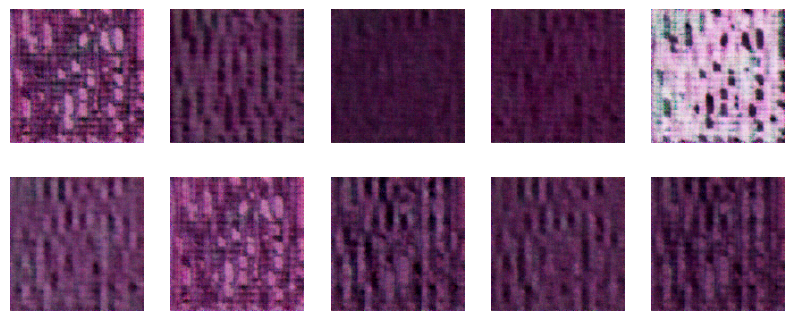

In [51]:
def plot_generated_images(images, num_rows=2, num_cols=5):
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Visualize the generated images
plot_generated_images(generated_images)